In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import featuretools as ft
import featuretools.variable_types as vtypes
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir('c:\\Users\\Artem\\Desktop\\neural networks\\HTRU2')
os.getcwd()

'c:\\Users\\Artem\\Desktop\\neural networks\\HTRU2'

In [3]:
data = pd.read_csv('HTRU_2.csv', header=None)
column_names = pd.read_csv('columns_names.txt',sep=" ", header=None)
data.columns = ["MeanIP","StdIP","ExckurtIP","SkewIP","MeanDMSNR","StdDMSNR","ExckurtDMSNR","SkewDMSNR", "class"]

In [4]:
data.columns = data.columns.map(str)

In [5]:
def plot_metrics(history): #для графиков функции потерь и точности в зависимости от эпохи
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+2)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1.2])

    plt.legend()

    

In [6]:
def plot_cm(labels, predictions, p=0.5): #для confusion_matrix
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('не пульсар предсказанный как не пульсар: ', cm[0][0])
  print('не пульсар предсказанный как пульсар :', cm[0][1])
  print('пульсар предсказанный как не пульсар :', cm[1][0])
  print('Пульсар предсказанный как пульсар : ', cm[1][1])

In [7]:
del data['class'] #удаляется последняя колонка с ответами для feature engeneering

In [8]:
ft.list_primitives()

,name,type,description
0,trend,aggregation,Calculates the trend of a variable over time.
1,skew,aggregation,Computes the extent to which a distribution di...
2,entropy,aggregation,Calculates the entropy for a categorical variable
3,n_most_common,aggregation,Determines the `n` most common elements.
4,count,aggregation,"Determines the total number of values, excludi..."
5,num_unique,aggregation,"Determines the number of distinct values, igno..."
6,all,aggregation,Calculates if all values are 'True' in a list.
7,min,aggregation,"Calculates the smallest value, ignoring `NaN` ..."
8,time_since_last,aggregation,Calculates the time elapsed since the last dat...
9,mean,aggregation,Computes the average for a list of values.


In [9]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'pulsars')
# adding a dataframe 
es.entity_from_dataframe(entity_id = 'signals', dataframe = data, index='number')

2020-05-20 20:16:01,682 featuretools.entityset - WARNING    index number not found in dataframe, creating new integer column


Entityset: pulsars
  Entities:
    signals [Rows: 17898, Columns: 9]
  Relationships:
    No relationships

In [10]:
es["signals"].variables 

[<Variable: number (dtype = index)>,
 <Variable: MeanIP (dtype = numeric)>,
 <Variable: StdIP (dtype = numeric)>,
 <Variable: ExckurtIP (dtype = numeric)>,
 <Variable: SkewIP (dtype = numeric)>,
 <Variable: MeanDMSNR (dtype = numeric)>,
 <Variable: StdDMSNR (dtype = numeric)>,
 <Variable: ExckurtDMSNR (dtype = numeric)>,
 <Variable: SkewDMSNR (dtype = numeric)>]

In [11]:
feature_matrix, feature_names=ft.dfs(entityset=es, target_entity = 'signals',max_depth = 2, verbose = 3, n_jobs = 1)
feature_matrix.head() #при первой попытке генрации признаков(при "no relationships" ничего не сгенерировалось)

Built 8 features
Elapsed: 00:00 | Progress: 100%|██████████


,MeanIP,StdIP,ExckurtIP,SkewIP,MeanDMSNR,StdDMSNR,ExckurtDMSNR,SkewDMSNR
number,,,,,,,,
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306


In [12]:
es = es.normalize_entity(base_entity_id='signals', new_entity_id='new_signals', index='MeanIP') #создаём relationship: выделяем столбец, на основе которого будут строиться общие признаки

In [13]:
print(es)

Entityset: pulsars
  Entities:
    signals [Rows: 17898, Columns: 9]
    new_signals [Rows: 8626, Columns: 1]
  Relationships:
    signals.MeanIP -> new_signals.MeanIP


In [17]:
feature_matrix, feature_names=ft.dfs(entityset=es, target_entity = 'signals',agg_primitives=["mean", "max", "min", "sum", "median"],verbose = 3, n_jobs = 1)
feature_matrix.head(15)

Built 43 features
Elapsed: 00:02 | Progress: 100%|██████████


,MeanIP,StdIP,ExckurtIP,SkewIP,MeanDMSNR,StdDMSNR,ExckurtDMSNR,SkewDMSNR,new_signals.MEAN(signals.MeanDMSNR),new_signals.MEAN(signals.StdIP),...,new_signals.SUM(signals.ExckurtDMSNR),new_signals.SUM(signals.ExckurtIP),new_signals.SUM(signals.StdDMSNR),new_signals.MEDIAN(signals.MeanDMSNR),new_signals.MEDIAN(signals.StdIP),new_signals.MEDIAN(signals.SkewIP),new_signals.MEDIAN(signals.SkewDMSNR),new_signals.MEDIAN(signals.ExckurtDMSNR),new_signals.MEDIAN(signals.ExckurtIP),new_signals.MEDIAN(signals.StdDMSNR)
number,,,,,,,,,,,,,,,,,,,,,
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,3.199833,55.683782,...,7.975532,-0.234571,19.110426,3.199833,55.683782,-0.699648,74.242225,7.975532,-0.234571,19.110426
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,2.066332,53.511202,...,28.611264,1.254831,45.756319,1.836957,52.275860,-0.246135,127.393580,10.360940,0.452962,14.860146
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,2.757107,44.041095,...,16.800342,0.932273,36.393436,2.757107,44.041095,0.636630,85.309060,8.400171,0.466137,18.196718
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,3.258361,52.347156,...,23.421843,-0.234461,58.706194,3.326923,49.955605,-0.375633,67.242135,7.752153,-0.068415,20.725051
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,1.178930,40.672225,...,14.269573,0.600866,11.468720,1.178930,40.672225,1.123492,252.567306,14.269573,0.600866,11.468720
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,7.000000,45.108904,...,14.602721,1.238749,66.592926,7.000000,45.108904,1.033085,72.641038,7.301360,0.619374,33.296463
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,38.548495,47.261860,...,35.239413,0.262698,129.733021,2.663462,47.513018,0.066080,91.395097,8.464385,0.054479,16.192914
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,2.247492,47.222829,...,31.168541,-0.313902,51.905838,2.678094,50.379206,-0.117718,106.652628,9.391858,-0.158323,16.535941
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,2.886407,49.722554,...,66.733454,2.728042,124.083662,2.331940,48.306153,0.123002,107.972506,9.001004,0.329787,14.486853


In [21]:
feature_matrix=feature_matrix.to_numpy()

In [24]:
xf_train, xf_valid, xf_test=np.split(feature_matrix, [14318,16108]) # подборка данных с feature engeneering

In [26]:
weight_for_0 = (1 / 16259)*(17898)/2.0 #замена значений весов
weight_for_1 = (1 / 1639)*(17898)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [27]:
#Ещё раз приходится считывать массив исходных данных data, поскольку до этого нужно было удалить столбец

data = pd.read_csv('HTRU_2.csv', header=None) 
column_names = pd.read_csv('columns_names.txt',sep=" ", header=None)
data.columns = ["MeanIP","StdIP","ExckurtIP","SkewIP","MeanDMSNR","StdDMSNR","ExckurtDMSNR","SkewDMSNR", "class"]

In [28]:
data=data.to_numpy()

In [29]:
x, y, z=np.split(data, [14318,16108])

In [30]:
x_train, y_train=np.hsplit(x, [8]) #нарезаем на тренировку
x_valid, y_valid=np.hsplit(y, [8]) #нарезаем на валидацию
x_test, y_test=np.hsplit(z,[8]) #нарезаем на тест

In [32]:
#Для данных с feature engeneering

model = tf.keras.models.Sequential([

tf.keras.layers.Dense(100, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(200, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history=model.fit(xf_train, y_train, epochs=100, validation_data=(xf_valid, y_valid), shuffle=True, class_weight = class_weight)
model.evaluate(xf_test, y_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 4:18 - loss: 13.5967 - accuracy: 0.500 - ETA: 11s - loss: 12.8818 - accuracy: 0.770 - ETA: 4s - loss: 11.0722 - accuracy: 0.7897 - ETA: 2s - loss: 10.0920 - accuracy: 0.784 - ETA: 1s - loss: 8.7645 - accuracy: 0.779 - ETA: 1s - loss: 7.7934 - accuracy: 0.78 - ETA: 0s - loss: 7.0799 - accuracy: 0.78 - ETA: 0s - loss: 6.3854 - accuracy: 0.78 - ETA: 0s - loss: 5.9519 - accuracy: 0.79 - ETA: 0s - loss: 5.5828 - accuracy: 0.79 - ETA: 0s - loss: 5.2615 - accuracy: 0.79 - ETA: 0s - loss: 5.0065 - accuracy: 0.79 - ETA: 0s - loss: 4.6998 - accuracy: 0.79 - 1s 97us/sample - loss: 4.5743 - accuracy: 0.7972 - val_loss: 0.1485 - val_accuracy: 0.9737
Epoch 2/100
14318/14318 [==============================] - ETA: 1s - loss: 0.3391 - accuracy: 0.87 - ETA: 0s - loss: 1.4688 - accuracy: 0.79 - ETA: 0s - loss: 1.2699 - accuracy: 0.81 - ETA: 0s - loss: 1.3069 - accuracy: 0.82 - ETA: 0s - loss:

[0.15179112383773208, 0.9860335]

In [62]:
def plot_metrics(history): #для графиков функции потерь и точности в зависимости от эпохи
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+2)
    plt.semilogy(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.semilogy(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    '''if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1.2])'''

    plt.legend()

    

In [49]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

In [50]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

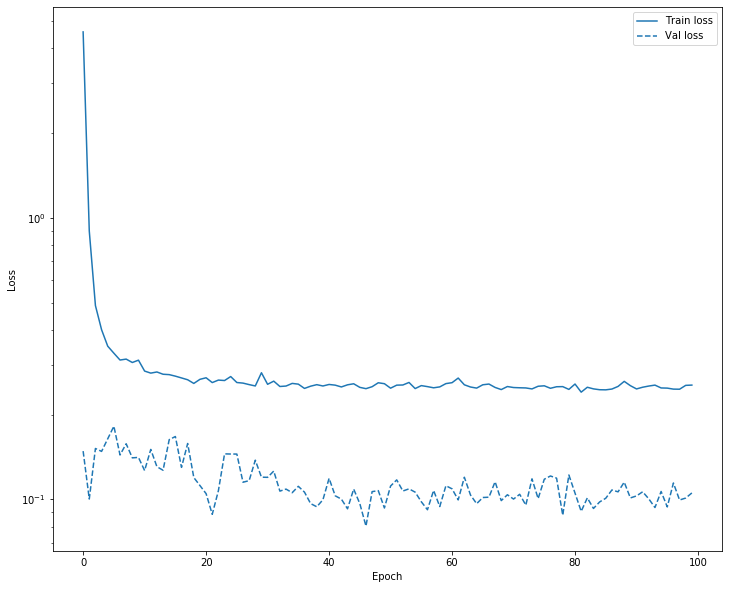

In [51]:
plot_loss(baseline_history, 'loss', 0)

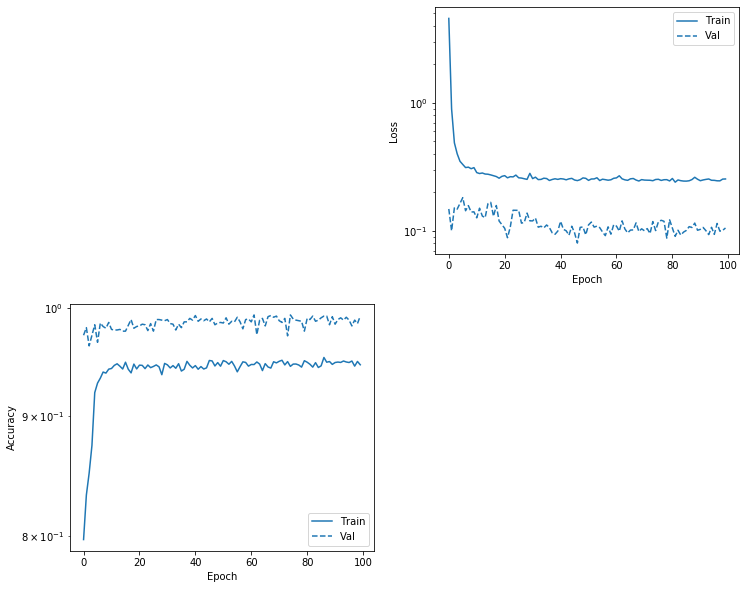

In [63]:
plot_metrics(baseline_history)

loss :  0.15179112383773208
accuracy :  0.9860335

не пульсар предсказанный как не пульсар:  1750
не пульсар предсказанный как пульсар : 13
пульсар предсказанный как не пульсар : 12
Пульсар предсказанный как пульсар :  15


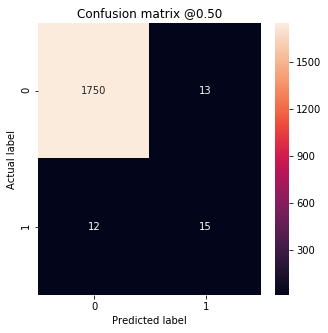

In [34]:
#для данных с feature engeneering

import seaborn as sns
test_predictions_baseline = model.predict(xf_test)

baseline_results = model.evaluate(xf_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [29]:
# далее всё тоже самое, только с данными без feature engeneering

In [35]:
#Для данных без feature engeneering

model = tf.keras.models.Sequential([
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history1=model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), shuffle=True, class_weight = class_weight)
model.evaluate(x_test, y_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 4:43 - loss: 34.4559 - accuracy: 0.437 - ETA: 8s - loss: 15.9131 - accuracy: 0.4527  - ETA: 3s - loss: 13.9739 - accuracy: 0.493 - ETA: 2s - loss: 11.5140 - accuracy: 0.522 - ETA: 1s - loss: 10.0574 - accuracy: 0.547 - ETA: 0s - loss: 8.7013 - accuracy: 0.568 - ETA: 0s - loss: 7.8552 - accuracy: 0.58 - ETA: 0s - loss: 7.0580 - accuracy: 0.59 - ETA: 0s - loss: 6.4085 - accuracy: 0.61 - ETA: 0s - loss: 5.9485 - accuracy: 0.61 - 1s 91us/sample - loss: 5.5731 - accuracy: 0.6238 - val_loss: 0.2031 - val_accuracy: 0.9291
Epoch 2/100
14318/14318 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.68 - ETA: 0s - loss: 1.2672 - accuracy: 0.69 - ETA: 0s - loss: 1.3615 - accuracy: 0.69 - ETA: 0s - loss: 1.3019 - accuracy: 0.70 - ETA: 0s - loss: 1.1990 - accuracy: 0.70 - ETA: 0s - loss: 1.1417 - accuracy: 0.70 - ETA: 0s - loss: 1.0884 - accuracy: 0.70 - ETA: 0s - los

[0.13977175416560148, 0.98044693]

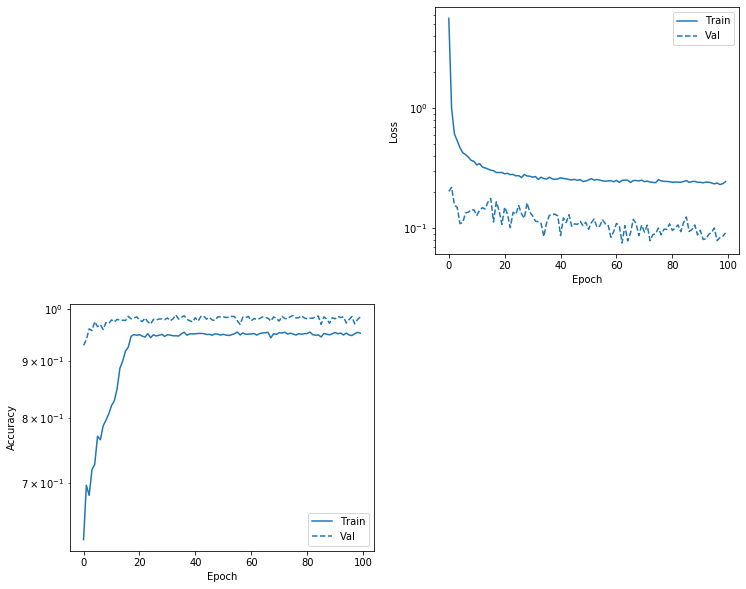

In [64]:
plot_metrics(baseline_history1)

loss :  0.13977175416560148
accuracy :  0.98044693

не пульсар предсказанный как не пульсар:  1733
не пульсар предсказанный как пульсар : 30
пульсар предсказанный как не пульсар : 5
Пульсар предсказанный как пульсар :  22


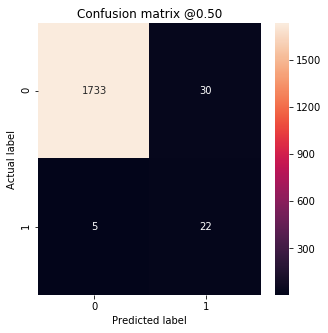

In [37]:
#для данных без feature engeneering


test_predictions_baseline = model.predict(x_test)

baseline_results = model.evaluate(x_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [66]:
# далее всё тоже самое, только с центрированными данными

In [67]:
datanorm = pd.read_csv('пульсары центрированные данные.csv', header=None)
#path = 'пульсары нормализованные.csv'
#myfile = open(path, mode = 'a')

In [68]:
datanorm.shape

(17898, 9)

In [69]:
datanorm=datanorm.to_numpy()

In [70]:
a, b, c=np.split(datanorm, [14318,16108])

In [71]:
a_train, b_train=np.hsplit(a, [8]) #нарезаем на тренировку
a_valid, b_valid=np.hsplit(b, [8]) #нарезаем на валидацию
a_test, b_test=np.hsplit(c,[8]) #нарезаем на тест

In [72]:
#модель с центрированными данными
model = tf.keras.models.Sequential([

tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])
baseline_history2=model.fit(a_train, b_train, epochs=100, validation_data=(a_valid, b_valid), shuffle=True, class_weight = class_weight)
model.evaluate(a_test, b_test, verbose=0)

Train on 14318 samples, validate on 1790 samples
Epoch 1/100
14318/14318 [==============================] - ETA: 3:44 - loss: 19.4905 - accuracy: 0.843 - ETA: 5s - loss: 14.8854 - accuracy: 0.7294  - ETA: 2s - loss: 11.3817 - accuracy: 0.673 - ETA: 1s - loss: 9.2868 - accuracy: 0.642 - ETA: 0s - loss: 7.6878 - accuracy: 0.64 - ETA: 0s - loss: 6.8922 - accuracy: 0.64 - ETA: 0s - loss: 6.1184 - accuracy: 0.65 - ETA: 0s - loss: 5.5581 - accuracy: 0.65 - ETA: 0s - loss: 5.1231 - accuracy: 0.66 - ETA: 0s - loss: 4.7361 - accuracy: 0.66 - 1s 91us/sample - loss: 4.6193 - accuracy: 0.6666 - val_loss: 0.3019 - val_accuracy: 0.7598
Epoch 2/100
14318/14318 [==============================] - ETA: 1s - loss: 3.9476 - accuracy: 0.65 - ETA: 0s - loss: 1.3008 - accuracy: 0.72 - ETA: 0s - loss: 1.1586 - accuracy: 0.71 - ETA: 0s - loss: 1.0640 - accuracy: 0.72 - ETA: 0s - loss: 1.0110 - accuracy: 0.72 - ETA: 0s - loss: 0.9818 - accuracy: 0.72 - ETA: 0s - loss: 0.9596 - accuracy: 0.72 - ETA: 0s - loss: 0

[0.1689125353064617, 0.97597766]

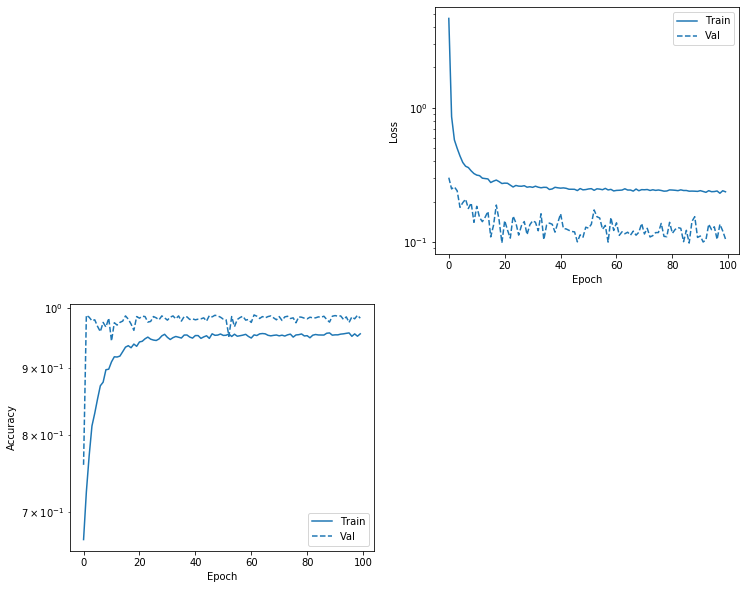

In [73]:
plot_metrics(baseline_history2)

loss :  0.1689125353064617
accuracy :  0.97597766

не пульсар предсказанный как не пульсар:  1724
не пульсар предсказанный как пульсар : 39
пульсар предсказанный как не пульсар : 4
Пульсар предсказанный как пульсар :  23


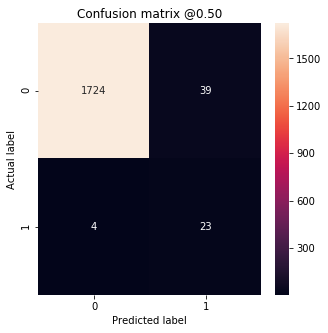

In [74]:
test_predictions_baseline = model.predict(a_test)
baseline_results = model.evaluate(a_test, b_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(b_test, test_predictions_baseline)

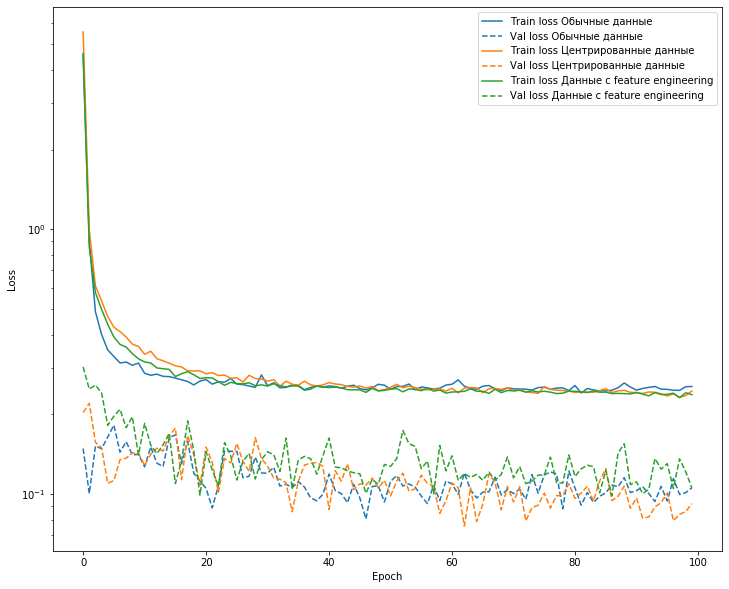

In [78]:
plot_loss(baseline_history, 'loss Обычные данные', 0)
plot_loss(baseline_history1, 'loss Центрированные данные', 1)
plot_loss(baseline_history2, 'loss Данные с feature engineering', 2)

#график для обучения со всеми типами данных